In [11]:
import cv2
import random
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from IPython.display import display

In [12]:
imagesDirectory = '../data/images/'

In [108]:
exampleIDs = """SFF_D_1013
zbz-990054280370205508
zbz-990054295100205508
nb-1003704
SFF_D_1578
nb-1001087
SFF_D_1376
SFF_D_1404.002
zbz-990053965050205508
nb-1002494
nb-1000929
SFF_D_1514
SFF_D_1505""".split("\n")

exampleImages = [join(imagesDirectory,d + '.jpg') for d in exampleIDs]

(110, 305, 579, 309)


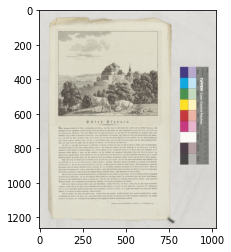

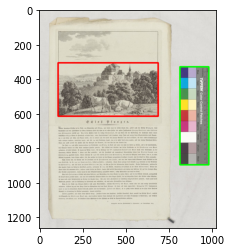

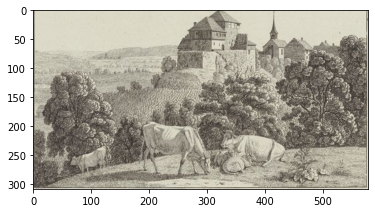

In [109]:
from matplotlib import pyplot as plt

class BSOImageCropping:
    
    showImages = False
    
    METHOD_TRHESH = 0
    METHOD_CANNY = 1

    SELECT_SQUAREST = 0
    SELECT_LARGEST = 1
    
    def __init__(self, showImages=False):
        self.showImages = showImages
    
    def blurImage(self, image, amount=5):
        return cv2.blur(image.copy(), (amount, amount))
    
    def cannyImage(self, image):
        return cv2.Canny(image.copy(), 10, 20)
    
    def displayImage(self, image):
        plt.figure()
        plt.imshow(image)
        
    def erodeImage(self, image, iterations=5):
        kernel = np.ones((5,5),np.uint8)
        return cv2.erode(image.copy(), kernel, iterations)
        
    def extendImage(self, image):
        return cv2.copyMakeBorder(image.copy(), self.extension, self.extension, self.extension, self.extension, cv2.BORDER_REPLICATE)
    
    def makeBW(self, image):
        return cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
        
    def thresholdImage(self, image):   
        padding = 5
        if image[image.shape[0]-padding][padding] > 127:
            thresholdMethod = cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
        else:
            thresholdMethod = cv2.THRESH_BINARY+cv2.THRESH_OTSU
        
        ret, thresh = cv2.threshold(image,0,255,thresholdMethod)   
        return thresh
    
    def cropImage(self, image, preprocessMethod=METHOD_TRHESH, selectMethod=SELECT_SQUAREST):        
        grayImage = self.makeBW(image)
        erodedImage = self.erodeImage(grayImage)
        blurImage = self.blurImage(grayImage)
        
        if preprocessMethod == self.METHOD_CANNY:
            thresh = self.cannyImage(blurImage)
        else:
            thresh = self.thresholdImage(blurImage)
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        contourImage = np.zeros(image.shape)
        cv2.drawContours(contourImage, contours, -1, (0,255,0), 3)
            
        areas = [cv2.contourArea(c) for c in contours]
        indicesOfLargestContours = [areas.index(x) for x in sorted(areas, reverse=True)[:2]]
        
        if selectMethod == self.SELECT_SQUAREST:
            ratios = []
            for i in indicesOfLargestContours:
                x,y,w,h = cv2.boundingRect(contours[i])
                ratios.append(max(w,h)/min(w,h))
            indexToPick = np.argmin(ratios)
        elif selectMethod == self.SELECT_LARGEST:
            indexToPick = 0
        
        drawThickness = 8
        
        rectangleImage = image.copy()
        for i in indicesOfLargestContours:
            x,y,w,h = cv2.boundingRect(contours[i])
            cv2.rectangle(rectangleImage, (x, y) , (x + w, y + h), (0,255,0) ,drawThickness)
        
        chosenX, chosenY, chosenW, chosenH = cv2.boundingRect(contours[indicesOfLargestContours[indexToPick]])
        cv2.rectangle(rectangleImage, (chosenX, chosenY), (chosenX + chosenW, chosenY + chosenH), (255,0,0), drawThickness)

        croppedImage = image.copy()[chosenY:chosenY+chosenH, chosenX:chosenX+chosenW]
        
        if self.showImages:
            self.displayImage(image)
            #self.displayImage(erodedImage)
            #self.displayImage(thresh)
            #self.displayImage(contourImage)
            self.displayImage(rectangleImage)
            self.displayImage(croppedImage)
            
        return chosenX, chosenY, chosenW, chosenH
            
            
detector = BSOImageCropping(showImages=True)
        
for filename in exampleImages[-1:]:
    image = cv2.imread(filename)
    image = image[:,:,::-1]
    if not 'zbz' in filename:
        print(detector.cropImage(image, selectMethod=BSOImageCropping.SELECT_LARGEST))
    else:
        print(detector.cropImage(image, selectMethod=BSOImageCropping.SELECT_SQUAREST))
    
    